In [20]:
import sklearn
from sklearn.datasets import make_circles

In [39]:
n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)


In [40]:
len(X), len(y)

(1000, 1000)

In [41]:
print(f"First five samples of X:\n {X[:5]}")
print(f"First five samples of y:\n {y[:5]}")

First five samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First five samples of y:
 [1 1 1 1 0]


In [42]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], 
                        "X2": X[:, 1],
                        "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


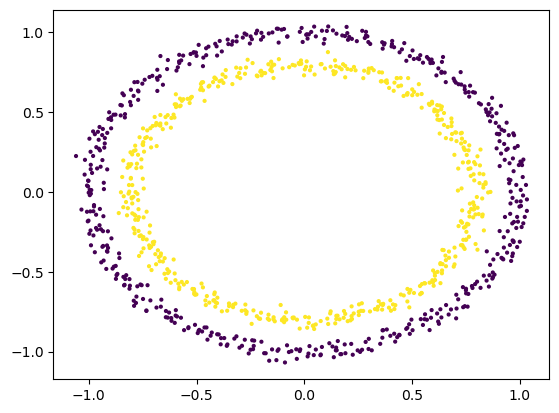

In [43]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0], y=X[:, 1], c=y, s=4, label="Training data")

In [44]:
X.shape, y.shape

((1000, 2), (1000,))

In [45]:
import torch
from torch import nn

# Load the data into tensors

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

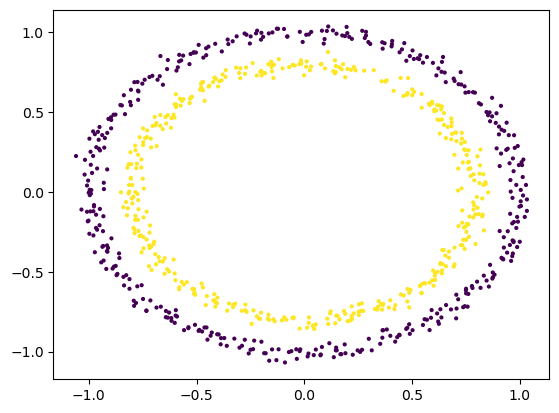

In [47]:
import matplotlib.pyplot as plt

plt.scatter(x=X_train[:, 0], y=X_train[:, 1], c=y_train, s=4, label="Training data")

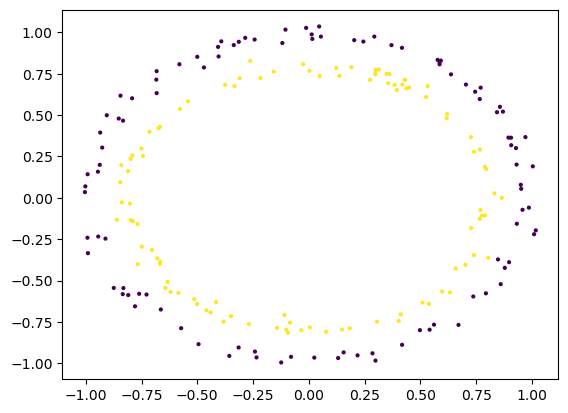

In [48]:
plt.scatter(x=X_test[:, 0], y=X_test[:, 1], c=y_test, s=4, label="Testing data")

In [49]:
# Build a model
import torch
from torch import nn

device="cpu"

X_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [50]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        pred = self.layer3(self.layer2(self.layer1(x)))
        return pred
    
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        pred = self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))
        return pred

def normalizePredictions(y_pred):
    vals = torch.sigmoid(y_pred)
    return torch.round(vals).squeeze()

In [51]:
torch.manual_seed(42)

model_0 = CircleModelV1()

In [52]:
with torch.inference_mode():
    # get prediction
    y_preds = model_0(X_test)
    y_preds = normalizePredictions(y_preds)
    
    print(y_preds[:10], y_train[:10])

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]) tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 0.])


In [53]:
import numpy as np

def calculate_accuracy(y_true, y_pred):   
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100    
    return acc
    
calculate_accuracy(y_test, y_preds)

50.0

In [54]:
# Loss and optimizer
loss_fn = nn.BCEWithLogitsLoss() # is combines BCE with sigmoid

optimizer = torch.optim.SGD(params = model_0.parameters(), lr=0.1)

In [55]:
# Training loop
torch.manual_seed(42)

epochs = 1500

train_epochs = []
train_loss_arr = []
test_loss_arr = []

for epoch in range(epochs):
    
    model_0.train();
    
    y_logits_train = model_0(X_train)
    
    y_pred_train = normalizePredictions(y_logits_train)
    
    train_acc = calculate_accuracy(y_pred_train, y_train)
    
    loss = loss_fn(y_logits_train.squeeze(), y_train)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model_0.eval()
        
    with torch.inference_mode():
        
        y_test_logits = model_0(X_test)
        
        y_test_preds = normalizePredictions(y_test_logits)
        
        test_acc = calculate_accuracy(y_test_preds, y_test)
        
        test_loss = loss_fn(y_test_logits.squeeze(), y_test)
        
        
        if epoch % 100 == 0 :
            train_epochs.append(epoch)
            
            train_loss_arr.append(loss.item())
            test_loss_arr.append(test_loss.item())
            
            print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Train Acc: {train_acc} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc} ")
    

Epoch: 0 | Train Loss: 0.69295 | Train Acc: 50.0 | Test Loss: 0.69319 | Test Acc: 50.0 
Epoch: 100 | Train Loss: 0.69115 | Train Acc: 52.87500000000001 | Test Loss: 0.69102 | Test Acc: 52.5 
Epoch: 200 | Train Loss: 0.68977 | Train Acc: 53.37499999999999 | Test Loss: 0.68940 | Test Acc: 55.00000000000001 
Epoch: 300 | Train Loss: 0.68795 | Train Acc: 53.0 | Test Loss: 0.68723 | Test Acc: 56.00000000000001 
Epoch: 400 | Train Loss: 0.68517 | Train Acc: 52.75 | Test Loss: 0.68411 | Test Acc: 56.49999999999999 
Epoch: 500 | Train Loss: 0.68102 | Train Acc: 52.75 | Test Loss: 0.67941 | Test Acc: 56.49999999999999 
Epoch: 600 | Train Loss: 0.67515 | Train Acc: 54.50000000000001 | Test Loss: 0.67285 | Test Acc: 56.00000000000001 
Epoch: 700 | Train Loss: 0.66659 | Train Acc: 58.375 | Test Loss: 0.66322 | Test Acc: 59.0 
Epoch: 800 | Train Loss: 0.65160 | Train Acc: 64.0 | Test Loss: 0.64757 | Test Acc: 67.5 
Epoch: 900 | Train Loss: 0.62362 | Train Acc: 74.0 | Test Loss: 0.62145 | Test Acc: 

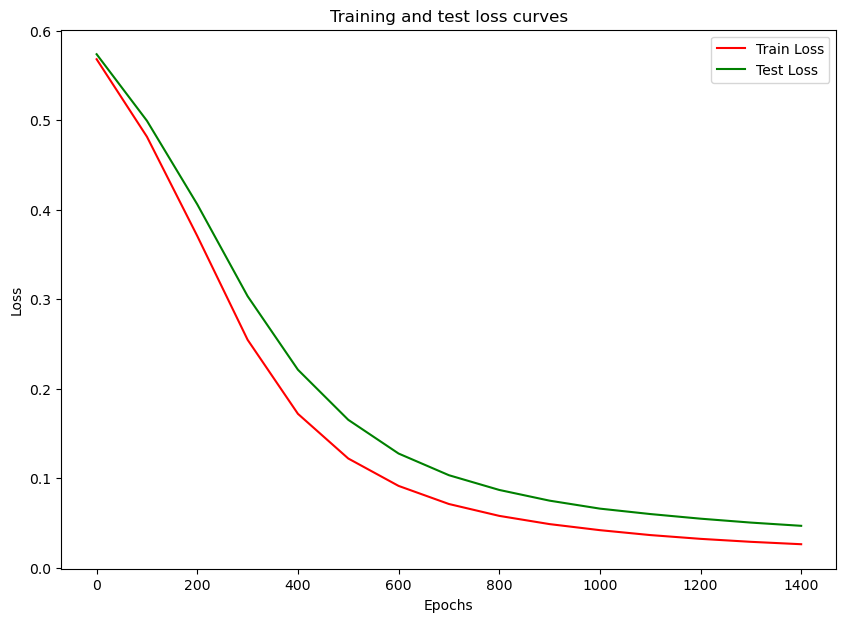

In [110]:
from helpers import plot_train_graph, plot_decision_boundary

plot_train_graph(x=train_epochs, y_train=train_loss_arr, y_test=test_loss_arr)

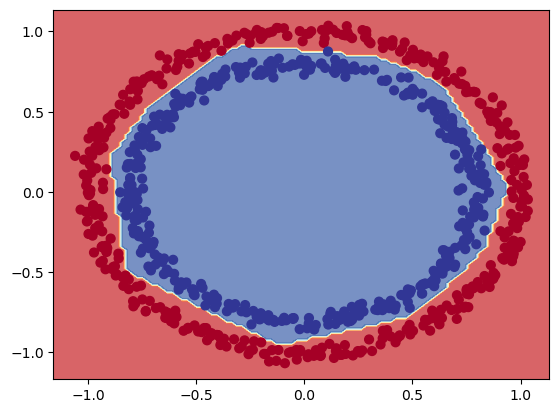

In [111]:
plot_decision_boundary(model_0, X_train, y_train)